# Dev Multi Tau

Written on Nov 7 2023 by Jess Breda

The goal of this notebook is to write a new child cases of experiment and design matrix generator that allows for more than previous violation columns to have a tau regressor. This will start by focusing on just prev_choice. 

Writing this will be a balance between moving quickly to see if it's worth having the prev_choice_exp regressor and being thoughtful about if I want any other exp regressors in the future.

In [297]:
import pandas as pd
import numpy as np

import pathlib
import sys
import seaborn as sns
from matplotlib import pyplot as plt

[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]

from design_matrix_generator import *
from get_rat_data import *
from fitting_utils import create_violation_interaction_pairs

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Design Matrix Generator with History

Here I am going to work to build a design matrix that makes a bse and then given a history_params dict, adds exp filter for each. Interactions pairs are optional and I will move this function into the parent class to allow for use of it. 

In [299]:
animal_ids = ["W078"]

df = get_rat_viol_data(animal_ids)

filter_params = {
    "prev_violation": 2,  # column to filter, tau of filter
    "prev_choice": 7,
}

returning viol data for ['W078']


In [302]:
dmgh = DesignMatrixGeneratorFilteredHistory("multi")

X, y = dmgh.generate_design_matrix(
    df, filter_params
)  # NOTE- commeneted! out the drop on line 92 of design_matrix_generator.py to make this

X

,bias,session,prev_violation,s_a,s_b,prev_sound_avg,prev_correct,prev_choice,prev_violation_exp,prev_choice_exp
0,1,1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,1,1,0,0.000000,0.000000,0.000000,-1.0,1.0,0.000000,0.149671
2,1,1,0,0.000000,0.000000,0.000000,-1.0,-1.0,0.000000,-0.019924
3,1,1,0,0.000000,0.000000,0.000000,-1.0,-1.0,0.000000,-0.166943
4,1,1,0,0.000000,0.000000,0.000000,-1.0,-1.0,0.000000,-0.294390
...,...,...,...,...,...,...,...,...,...,...
53294,1,200,0,1.579978,0.869187,-1.336899,1.0,1.0,0.000000,0.341044
53295,1,200,0,-0.860656,0.050722,1.340593,1.0,-1.0,0.000000,0.144964
53296,1,200,0,-0.860656,-1.586208,-0.444402,-1.0,-1.0,0.000000,-0.025013
53297,1,200,1,-1.674200,-0.767743,-0.000000,0.0,0.0,0.396139,-0.022692


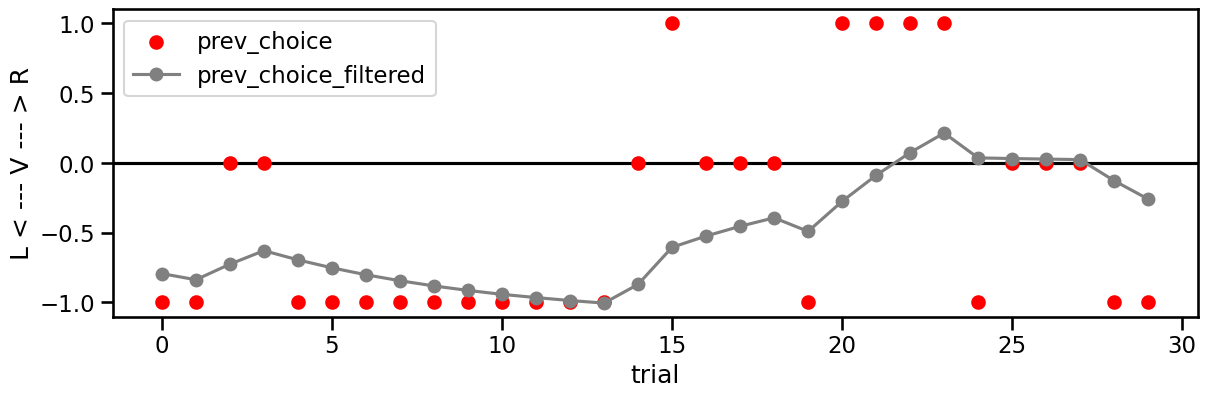

In [303]:
sub_data = X[X["session"] == 50][25:55]

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(
    x=range(len(sub_data["prev_choice"])),
    y=sub_data["prev_choice"].values,
    color="red",
    label="prev_choice",
)

ax.plot(
    # x=range(len(sub_data["prev_choice"])),
    sub_data["prev_choice_exp"].values,
    color="gray",
    label="prev_choice_filtered",
    marker="o",
)

ax.axhline(y=0, color="black", zorder=0)

ax.set(
    xlabel="trial",
    ylabel="L < --- V --- > R",
)

ax.legend()

Okay great- things are looking pretty good. Lets add the option for interaction terms

In [304]:
dmgh = DesignMatrixGeneratorFilteredHistory("multi")

X, y = dmgh.generate_design_matrix(
    df,
    filter_params,
    interaction_pairs=create_violation_interaction_pairs(["s_a", "s_b"]),
)

X

,bias,session,s_a,s_b,prev_sound_avg,prev_correct,prev_violation_exp,prev_choice_exp,prev_violation_exp_x_s_a,prev_violation_exp_x_s_b
0,1,1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,1,1,0.000000,0.000000,0.000000,-1.0,0.000000,0.149671,0.000000,0.000000
2,1,1,0.000000,0.000000,0.000000,-1.0,0.000000,-0.019924,0.000000,0.000000
3,1,1,0.000000,0.000000,0.000000,-1.0,0.000000,-0.166943,0.000000,0.000000
4,1,1,0.000000,0.000000,0.000000,-1.0,0.000000,-0.294390,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
53294,1,200,1.579978,0.869187,-1.336899,1.0,0.000000,0.341044,0.000000,0.000000
53295,1,200,-0.860656,0.050722,1.340593,1.0,0.000000,0.144964,-0.000000,0.000000
53296,1,200,-0.860656,-1.586208,-0.444402,-1.0,0.000000,-0.025013,-0.000000,-0.000000
53297,1,200,-1.674200,-0.767743,-0.000000,0.0,0.396139,-0.022692,-0.663215,-0.304133


Okay- the design matrix is all set up. Now it's time to make te experiment class.

## Experiment Tau Sweep

In [307]:
from multiclass_logistic_regression import MultiClassLogisticRegression

params = {
    "animals": ["W075", "W078"],
    "sigmas": [0.07, 0.13],
    "taus": [1, 2, 3],
    "random_state": 47,
    "tau_sweep": {
        "prev_violation": False,
        "prev_choice": True,
    },
    "model_config": {
        "tau_sweep_prev_choice": {
            "model_class": MultiClassLogisticRegression,
            "model_type": "multi",
            "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
            "design_matrix_generator_args": {"interaction_pairs": None},
        }
    },
}

In [308]:
from experiment_tau_sweep import ExperimentTauSweep

test = ExperimentTauSweep(params)
test.run()

returning viol data for ['W075', 'W078']

 >>>> evaluating animal W075 sweeping taus of prev_choice <<<<

 ***** evaluating tau 1, sigma 0.07 *****
         Current function value: 42579.609896
         Iterations: 24
         Function evaluations: 140
         Gradient evaluations: 121

 ***** evaluating tau 1, sigma 0.13 *****
Optimization terminated successfully.
         Current function value: 42258.808420
         Iterations: 27
         Function evaluations: 37
         Gradient evaluations: 37

 ***** evaluating tau 2, sigma 0.07 *****
         Current function value: 42545.420557
         Iterations: 24
         Function evaluations: 32
         Gradient evaluations: 32

 ***** evaluating tau 2, sigma 0.13 *****
         Current function value: 42214.705345
         Iterations: 25
         Function evaluations: 34
         Gradient evaluations: 34

 ***** evaluating tau 3, sigma 0.07 *****
         Current function value: 42557.504167
         Iterations: 26
         Function 

In [312]:
test.fit_models

,animal_id,model_name,model_type,nll,sigma,features,weights,n_train_trials,n_test_trials,prev_violation_tau,prev_choice_tau
0,W075,tau_sweep_prev_choice,multi,10082.037830,0.07,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.3092295413066796, 0.2690407116971256, -0.5...",45703,10832,6.0,1.0
1,W075,tau_sweep_prev_choice,multi,10048.082946,0.13,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.36724045238195324, 0.30728819146358766, -0...",45703,10832,6.0,1.0
2,W075,tau_sweep_prev_choice,multi,10064.828507,0.07,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.3100498831083352, 0.26783346312218376, -0....",45703,10832,6.0,2.0
3,W075,tau_sweep_prev_choice,multi,10031.000967,0.13,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.36770741914844673, 0.3061164164374315, -0....",45703,10832,6.0,2.0
4,W075,tau_sweep_prev_choice,multi,10057.958412,0.07,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.31133995636953266, 0.26725607698090287, -0...",45703,10832,6.0,3.0
5,W075,tau_sweep_prev_choice,multi,10023.812468,0.13,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.3689593356743234, 0.3054138613239409, -0.6...",45703,10832,6.0,3.0
6,W078,tau_sweep_prev_choice,multi,7518.798072,0.07,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.3678358142683213, 0.3620618637468263, -0.7...",31403,8461,2.0,1.0
7,W078,tau_sweep_prev_choice,multi,7505.162613,0.13,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.3968373799132351, 0.4100977283748035, -0.8...",31403,8461,2.0,1.0
8,W078,tau_sweep_prev_choice,multi,7507.736863,0.07,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.36929436723099857, 0.3603325626725628, -0....",31403,8461,2.0,2.0
9,W078,tau_sweep_prev_choice,multi,7491.375541,0.13,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.398138879851586, 0.4081127776898913, -0.80...",31403,8461,2.0,2.0


## Model Visualizer Tau Sweep

In [313]:
from model_visualizer import ModelVisualizerTauSweep

mct = ModelVisualizerTauSweep(test)

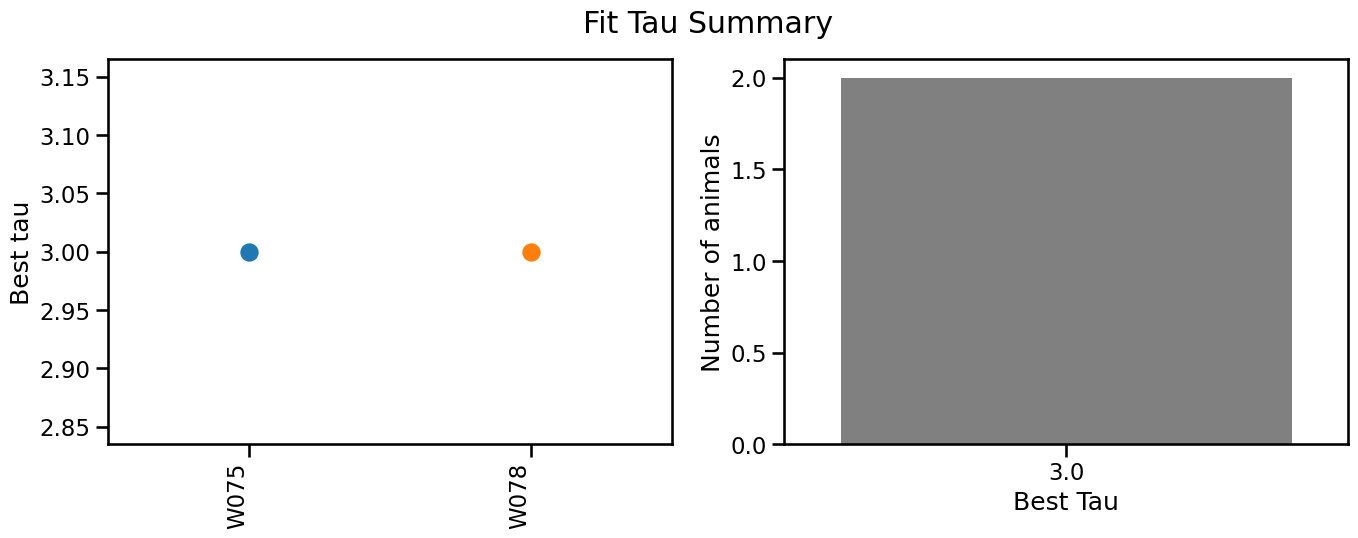

In [314]:
mct.plot_tau_summary()

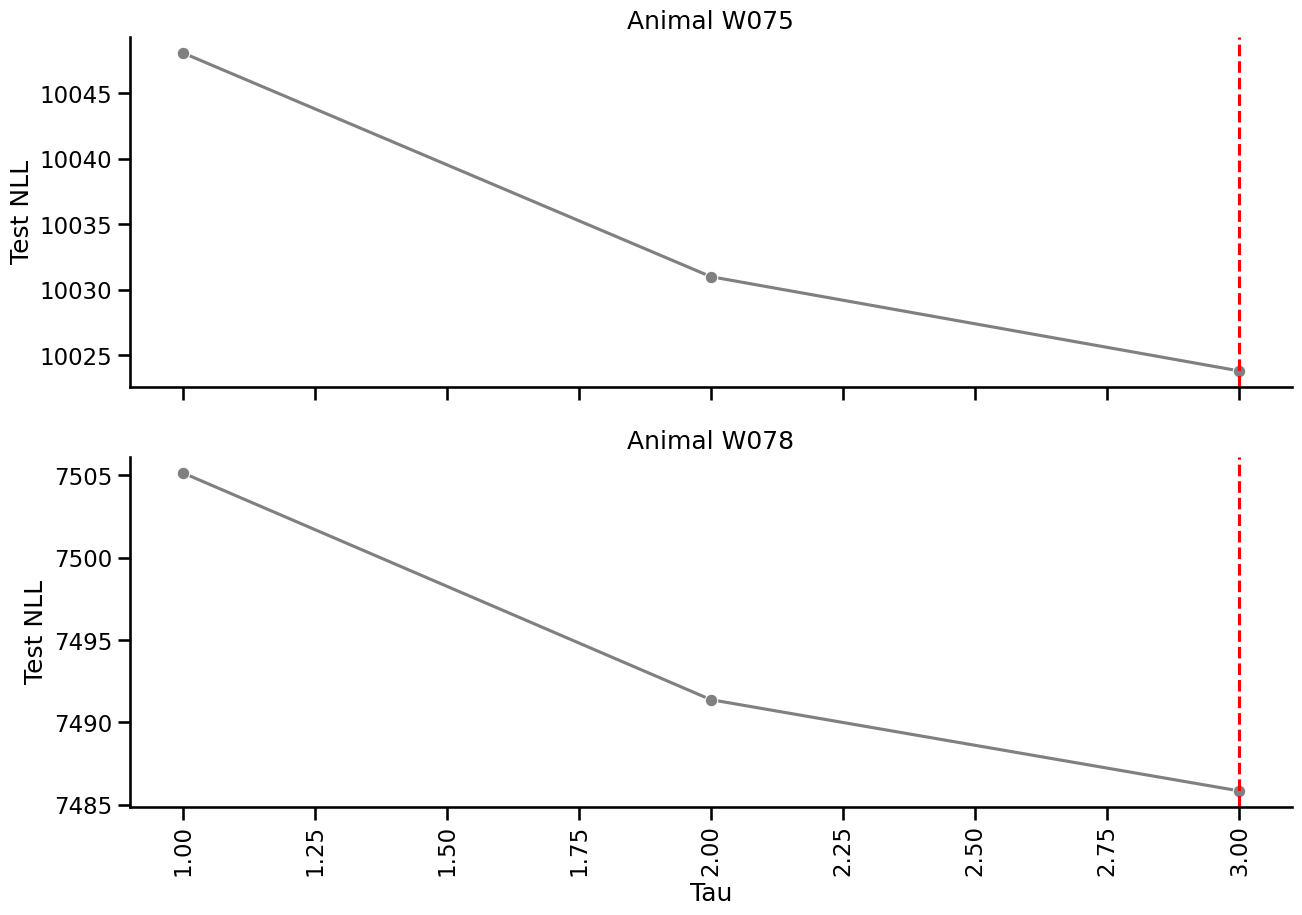

In [328]:
mct.plot_nll_over_taus_by_animal(group="tau", color="gray")

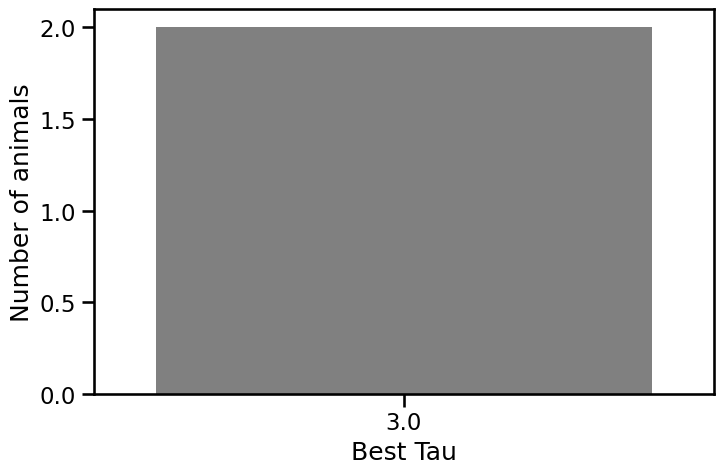

In [316]:
mct.plot_best_tau_counts()

In [317]:
mct.tau_columns

['prev_violation_tau', 'prev_choice_tau']

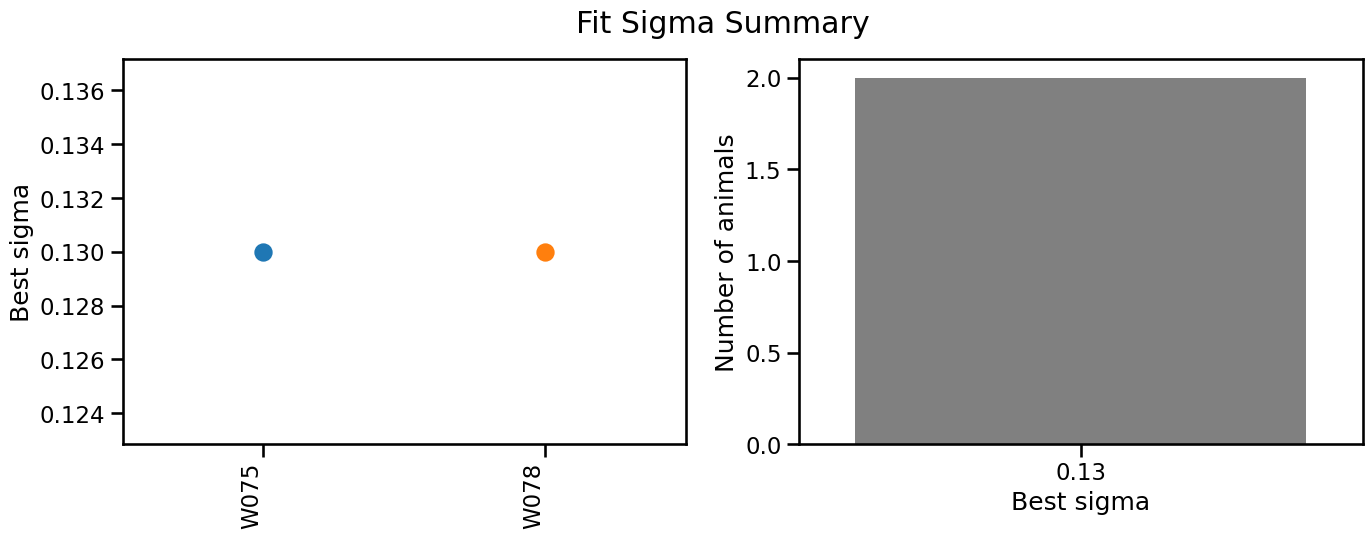

In [318]:
mct.plot_sigma_summary()

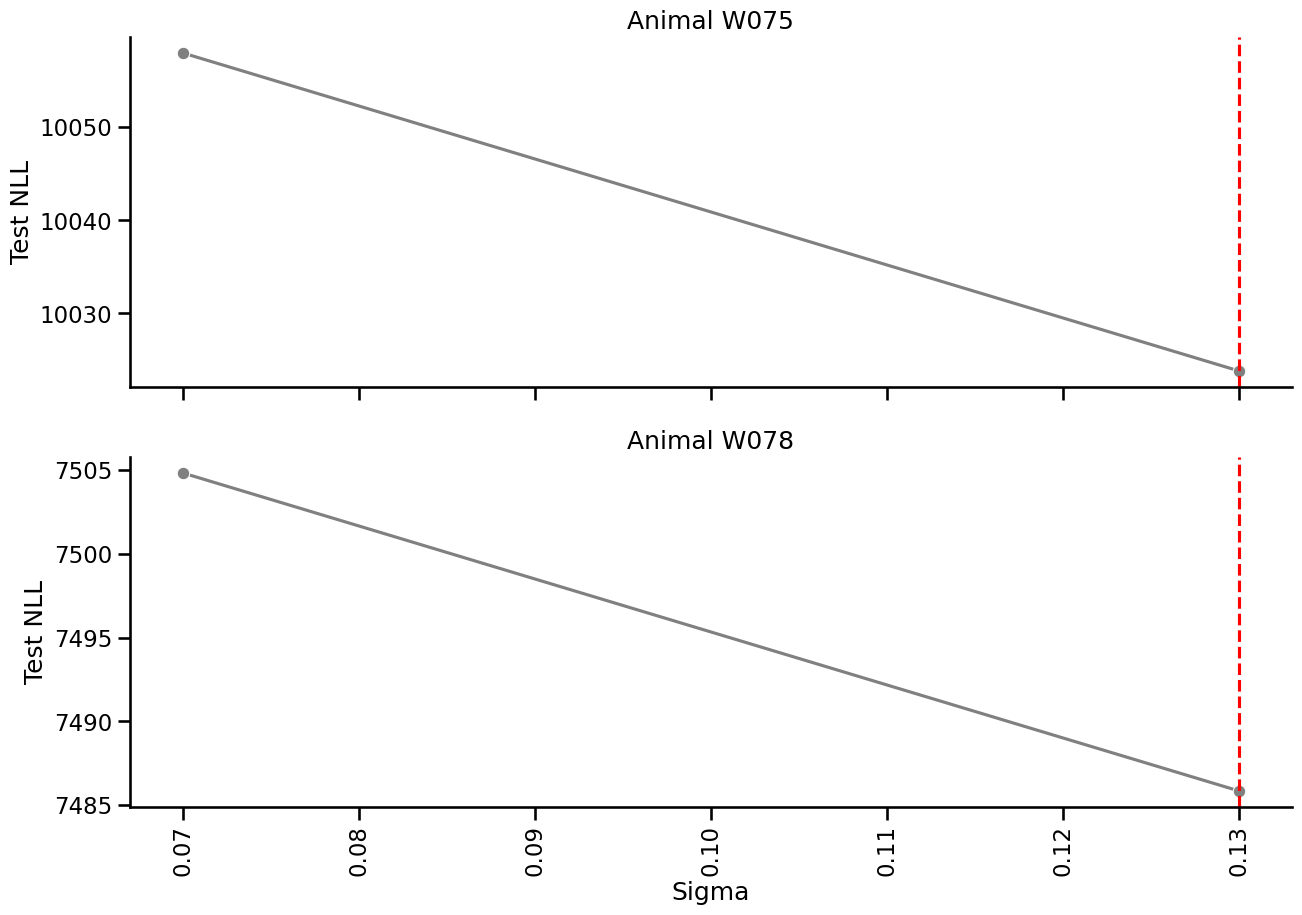

In [319]:
mct.plot_nll_over_sigmas_by_animal(color="gray")

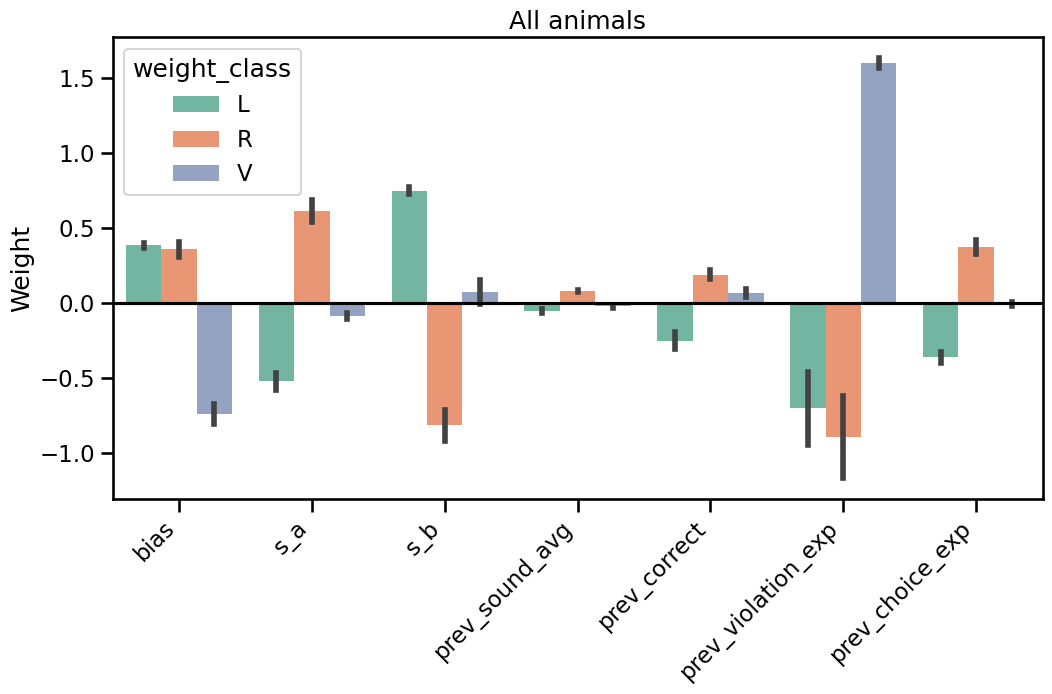

In [320]:
mct.plot_weights_summary(palette="Set2")

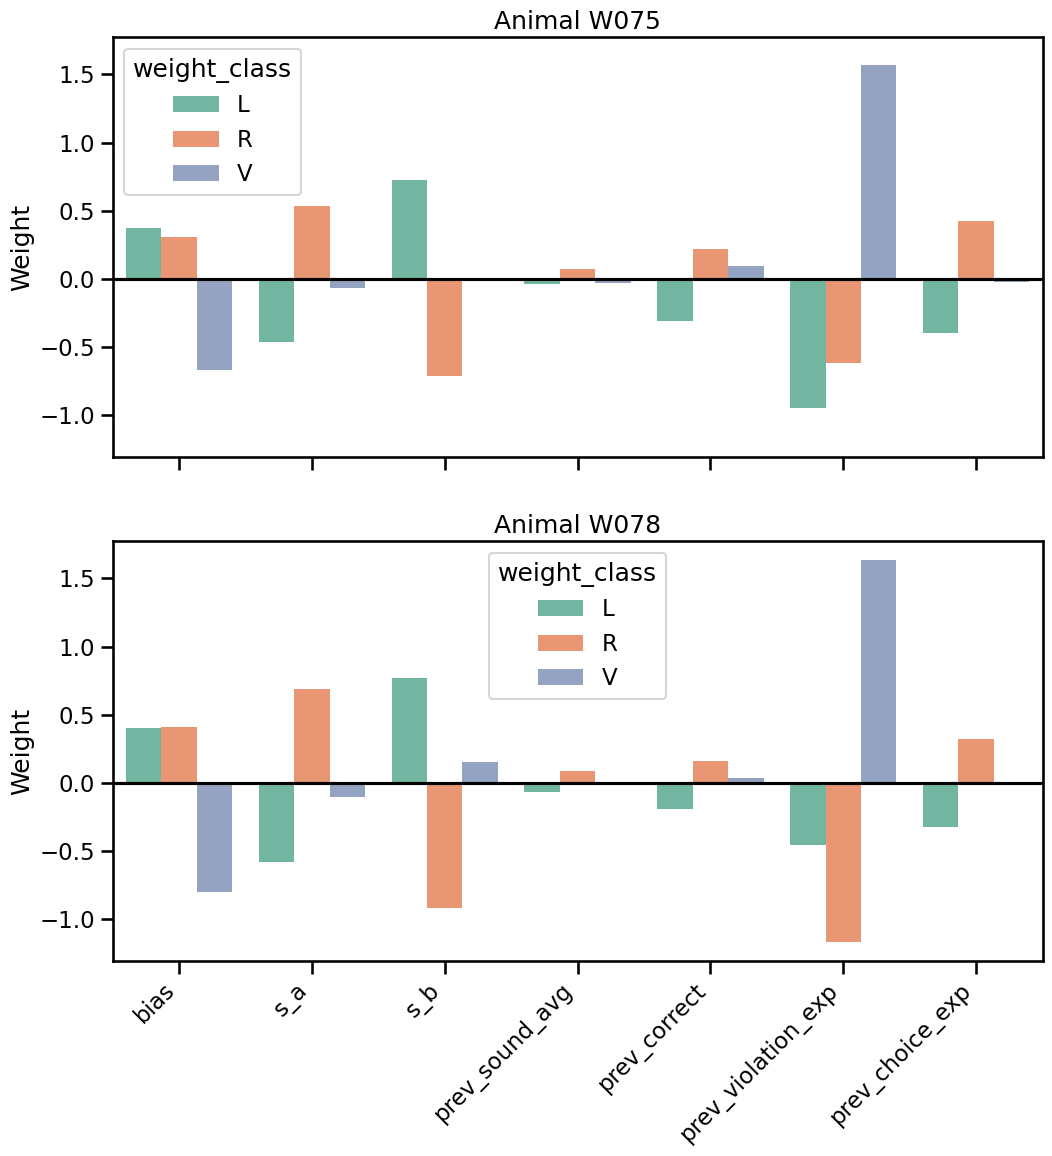

In [322]:
mct.plot_weights_by_animal(palette="Set2")